In [20]:
import os
import cv2
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
# from scipy.spatial.distance import bhattacharyya


In [214]:
# 配置
data_path = r'C:\VIP\4\caltech-101\101_ObjectCategories'
# categories = ['airplanes', 'motorbikes', 'Faces', 'leopards', 'watch']  # 示例类别
train_size = 50  # 每个类别的训练图像数量
test_size = 50   # 每个类别的测试图像数量

# 获取所有类别（文件夹名）
all_categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# 指定要选择的类别数量（例如5或10）
n = 20# 将此值改为10以选择10个类别

# 固定随机种子
seed = 10
random.seed(seed)

# 检查请求的类别数量是否超过可用类别数量
if n > len(all_categories):
    raise ValueError(f"请求选择的类别数量({n})超过了可用的类别总数({len(all_categories)})。")

# 随机选择n个类别
categories = random.sample(all_categories, n)
print(f"选择的类别：{categories}")

def load_image_paths(data_path, categories, train_size, test_size):
    image_paths = defaultdict(list)
    for category in categories:
        category_path = os.path.join(data_path, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith('.jpg')]
        total_images = len(images)

        # 检查图像总数是否足够
        if total_images < 2 * train_size:
            # 重新计算 train_size 和 test_size
            train_size_adjusted = total_images // 2
            test_size_adjusted = total_images - train_size_adjusted
        else:
            train_size_adjusted = train_size
            test_size_adjusted = test_size

        random.shuffle(images)
        image_paths['train'].extend(images[:train_size_adjusted])
        image_paths['test'].extend(images[train_size_adjusted:train_size_adjusted+test_size_adjusted])
    return image_paths



image_paths = load_image_paths(data_path, categories, train_size, test_size)

print(f"训练图像数量: {len(image_paths['train'])}")
print(f"测试图像数量: {len(image_paths['test'])}")


选择的类别：['pizza', 'BACKGROUND_Google', 'ketch', 'mandolin', 'airplanes', 'crocodile_head', 'lobster', 'mayfly', 'euphonium', 'sea_horse', 'chandelier', 'Motorbikes', 'flamingo_head', 'bonsai', 'dragonfly', 'watch', 'hawksbill', 'barrel', 'kangaroo', 'ceiling_fan']
训练图像数量: 717
测试图像数量: 725


In [ ]:
# 配置
data_path = r'C:\VIP\4\caltech-101\101_ObjectCategories'
# categories = ['airplanes', 'motorbikes', 'Faces', 'leopards', 'watch']  # 示例类别
# train_size = 10  # 每个类别的训练图像数量
# test_size = 10   # 每个类别的测试图像数量

# 获取所有类别（文件夹名）
all_categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# 指定要选择的类别数量（例如5或10）
n = 20# 将此值改为10以选择10个类别

# 固定随机种子
seed = 10
random.seed(seed)

# 检查请求的类别数量是否超过可用类别数量
if n > len(all_categories):
    raise ValueError(f"请求选择的类别数量({n})超过了可用的类别总数({len(all_categories)})。")

# 随机选择n个类别
categories = random.sample(all_categories, n)
print(f"选择的类别：{categories}")

def load_image_paths(data_path, categories, train_ratio=0.7):
    """
    加载图像路径，并根据train_ratio将图像分配到训练集和测试集。

    Parameters:
    - data_path (str): 数据集的根路径。
    - categories (list): 要选择的类别列表。
    - train_ratio (float): 训练集所占比例。

    Returns:
    - dict: 包含训练集和测试集图像路径的字典。
    """
    image_paths = defaultdict(list)
    for category in categories:
        category_path = os.path.join(data_path, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith('.jpg')]
        random.shuffle(images)  # 随机打乱图像顺序

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_test = n_total - n_train

        image_paths['train'].extend(images[:n_train])
        image_paths['test'].extend(images[n_train:])

        print(f"类别 '{category}'：总图像数={n_total}, 训练集={n_train}, 测试集={n_test}")
    return image_paths

from collections import defaultdict

# 设置训练集比例
train_ratio = 0.5  # 50%训练，50%测试

# 加载图像路径
image_paths = load_image_paths(data_path, categories, train_ratio=train_ratio)
print(f"训练图像数量: {len(image_paths['train'])}")
print(f"测试图像数量: {len(image_paths['test'])}")

In [215]:
# 初始化 SIFT 检测器
sift = cv2.SIFT_create()

def extract_sift_features(image_paths):
    descriptors_list = []
    image_descriptors = {}
    for img_path in tqdm(image_paths, desc="提取 SIFT 特征"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"警告: 无法读取图像 {img_path}。跳过。")
            continue
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
            image_descriptors[img_path] = descriptors
    return descriptors_list, image_descriptors

train_descriptors_list, train_image_descriptors = extract_sift_features(image_paths['train'])


提取 SIFT 特征: 100%|██████████| 717/717 [00:09<00:00, 74.12it/s] 


In [243]:
# 参数
k = 2000  # 聚类数量（视觉词汇）

# 将所有描述符垂直连接成一个矩阵
all_descriptors = np.vstack(train_descriptors_list)
print(f"K-Means 聚类的总描述符数量: {all_descriptors.shape}")

# 执行 K-Means 聚类
print("执行 K-Means 聚类以构建代码本...")
kmeans = KMeans(n_clusters=k, random_state=42, verbose=1)
kmeans.fit(all_descriptors)
codebook = kmeans.cluster_centers_
print("代码本生成完成。")


K-Means 聚类的总描述符数量: (350494, 128)
执行 K-Means 聚类以构建代码本...


c:\Users\f4848\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 30250977280.0.
Iteration 1, inertia 22455775232.0.
Iteration 2, inertia 22038452224.0.
Iteration 3, inertia 21861074944.0.
Iteration 4, inertia 21759498240.0.
Iteration 5, inertia 21691889664.0.
Iteration 6, inertia 21643186176.0.
Iteration 7, inertia 21605881856.0.
Iteration 8, inertia 21576321024.0.
Iteration 9, inertia 21552910336.0.
Iteration 10, inertia 21533845504.0.
Iteration 11, inertia 21517860864.0.
Iteration 12, inertia 21504270336.0.
Iteration 13, inertia 21492617216.0.
Iteration 14, inertia 21482555392.0.
Iteration 15, inertia 21473773568.0.
Iteration 16, inertia 21466060800.0.
Iteration 17, inertia 21459044352.0.
Iteration 18, inertia 21452787712.0.
Iteration 19, inertia 21446815744.0.
Iteration 20, inertia 21441546240.0.
Iteration 21, inertia 21436827648.0.
Iteration 22, inertia 21432729600.0.
Iteration 23, inertia 21429051392.0.
Iteration 24, inertia 21425799168.0.
Iteration 25, inertia 21422827520.0.
Iteration 26, inertia 21

In [244]:
# 视觉词袋（BoW）直方图构建
def compute_bow_histograms(image_descriptors, codebook):
    k = codebook.shape[0]
    histograms = {}
    for img_path, descriptors in tqdm(image_descriptors.items(), desc="计算 BoW 直方图"):
        if descriptors is not None:
            # 将每个描述符分配到最近的聚类中心
            words = pairwise_distances_argmin(descriptors, codebook)
            # 构建直方图
            histogram, _ = np.histogram(words, bins=np.arange(k+1))
            # 归一化直方图
            histogram = histogram.astype(float)
            histogram /= (histogram.sum() + 1e-7)
            histograms[img_path] = histogram
    return histograms

train_histograms = compute_bow_histograms(train_image_descriptors, codebook)


计算 BoW 直方图: 100%|██████████| 717/717 [00:21<00:00, 33.12it/s]


In [245]:
# 提取测试图像的 SIFT 特征
test_descriptors_list, test_image_descriptors = extract_sift_features(image_paths['test'])

# 计算测试图像的 BoW 直方图
test_histograms = compute_bow_histograms(test_image_descriptors, codebook)


计算 BoW 直方图: 100%|██████████| 725/725 [00:21<00:00, 33.13it/s]


In [246]:
# 索引表构建与保存
def create_image_table(train_histograms, test_histograms, categories, data_path, split):
    data = []
    if split == 'train':
        for img_path, histogram in train_histograms.items():
            category = os.path.basename(os.path.dirname(img_path))
            data.append({
                'file_name': img_path,
                'category': category,
                'split': split,
                'histogram': histogram
            })
    elif split == 'test':
        for img_path, histogram in test_histograms.items():
            category = os.path.basename(os.path.dirname(img_path))
            data.append({
                'file_name': img_path,
                'category': category,
                'split': split,
                'histogram': histogram
            })
    return data

# 创建图像表
train_data = create_image_table(train_histograms, test_histograms=None, categories=categories, data_path=data_path, split='train')
test_data = create_image_table(train_histograms, test_histograms=test_histograms, categories=categories, data_path=data_path, split='test')

# 合并为一个 DataFrame
image_table = pd.DataFrame(train_data + test_data)
print(image_table.head())



                                           file_name category  split  \
0  C:\VIP\4\caltech-101\101_ObjectCategories\pizz...    pizza  train   
1  C:\VIP\4\caltech-101\101_ObjectCategories\pizz...    pizza  train   
2  C:\VIP\4\caltech-101\101_ObjectCategories\pizz...    pizza  train   
3  C:\VIP\4\caltech-101\101_ObjectCategories\pizz...    pizza  train   
4  C:\VIP\4\caltech-101\101_ObjectCategories\pizz...    pizza  train   

                                           histogram  
0  [0.0, 0.0008857395924813339, 0.001771479184962...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0033003300319140822, 0.0, 0.0, 0.0, 0.0, 0....  
3  [0.0, 0.0007117437721913349, 0.0, 0.0, 0.00071...  
4  [0.0, 0.0011890606419513602, 0.001189060641951...  


In [247]:
image_table.to_pickle('image_table.pkl')
print("图像表已保存到 'image_table.pkl'。")


图像表已保存到 'image_table.pkl'。


In [248]:
def compute_similarity(query_hist, train_histograms, method='dot'):
    similarities = {}
    if method == 'dot':
        # 使用点积计算公共词
        for idx, row in train_histograms.iterrows():
            similarities[row['file_name']] = np.dot(query_hist, row['histogram'])
    elif method == 'tfidf':
        # TF-IDF 相似度
        # 计算文档频率
        df = np.sum([row['histogram'] > 0 for idx, row in train_histograms.iterrows()], axis=0)
        idf = np.log((1.0 * len(train_histograms)) / (df + 1))
        # 计算查询的 TF-IDF
        tfidf_query = query_hist * idf
        for idx, row in train_histograms.iterrows():
            tfidf_train = row['histogram'] * idf
            similarities[row['file_name']] = np.dot(tfidf_query, tfidf_train)
    # elif method == 'bhattacharyya':
    #     # Bhattacharyya 距离
    #     for idx, row in train_histograms.iterrows():
    #         similarity = 1 - bhattacharyya(query_hist, row['histogram'])
    #         similarities[row['file_name']] = similarity
    else:
        raise ValueError("未知的相似度方法。")
    return similarities


In [112]:
#直接引入.pkl
# 指定 image_table.pkl 的路径
image_table_path = 'image_table_5_n10_k300.pkl'  # 如果文件在其他路径，请修改为相应的路径

# 加载 image_table.pkl
try:
    image_table = pd.read_pickle(image_table_path)
    print(f"成功加载图像表 '{image_table_path}'。")
except FileNotFoundError:
    print(f"错误: 找不到文件 '{image_table_path}'。请确保文件路径正确。")
    exit(1)

成功加载图像表 'image_table_5_n10_k300.pkl'。


In [254]:
def retrieve_and_evaluate(image_table, query_split='train', similarity_method='dot'):
    queries = image_table[image_table['split'] == query_split]
    train_set = image_table[image_table['split'] == 'train']
    
    mrr_total = 0
    top3_count = 0
    total_queries = len(queries)
    
    for _, query in tqdm(queries.iterrows(), total=queries.shape[0], desc=f"使用 {similarity_method} 方法检索 {query_split} 集合"):
        similarities = compute_similarity(query['histogram'], train_set, method=similarity_method)
        # 按相似度排序
        sorted_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
        # 查找排名
        ranks = 1
        for file, sim in sorted_similar:
            if image_table.loc[image_table['file_name'] == file, 'category'].values[0] == query['category']:
                mrr_total += 1.0 / ranks
                if ranks <= 3:
                    top3_count += 1
                break
            ranks += 1
    mrr = mrr_total / total_queries
    top3 = (top3_count / total_queries) * 100
    return mrr, top3

# 对训练查询进行评估
mrr_train_dot, top3_train_dot = retrieve_and_evaluate(image_table, query_split='train', similarity_method='dot')
# mrr_train_bhattacharyya, top3_train_bhattacharyya = retrieve_and_evaluate(image_table, query_split='train', similarity_method='bhattacharyya')

# 对测试查询进行评估
mrr_test_dot, top3_test_dot = retrieve_and_evaluate(image_table, query_split='test', similarity_method='dot')
# mrr_test_bhattacharyya, top3_test_bhattacharyya = retrieve_and_evaluate(image_table, query_split='test', similarity_method='bhattacharyya')

# 显示结果
results = pd.DataFrame({
    '集合': ['训练集', '测试集'],
    'MRR（点积）': [mrr_train_dot, mrr_test_dot],
    '前3名准确率（点积）': [top3_train_dot, top3_test_dot],
    # 'MRR（Bhattacharyya）': [mrr_train_bhattacharyya, mrr_test_bhattacharyya],
    # '前3名准确率（Bhattacharyya）': [top3_train_bhattacharyya, top3_test_bhattacharyya],
})

print(results)


使用 dot 方法检索 test 集合: 100%|██████████| 725/725 [00:12<00:00, 58.65it/s]

    集合   MRR（点积）  前3名准确率（点积）
0  训练集  0.319533   37.796374
1  测试集  0.991632   99.862069


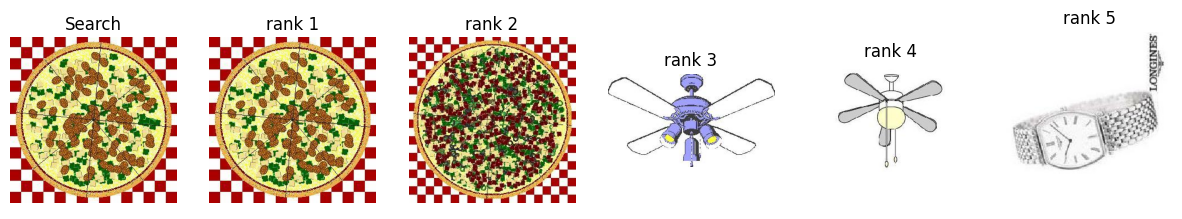

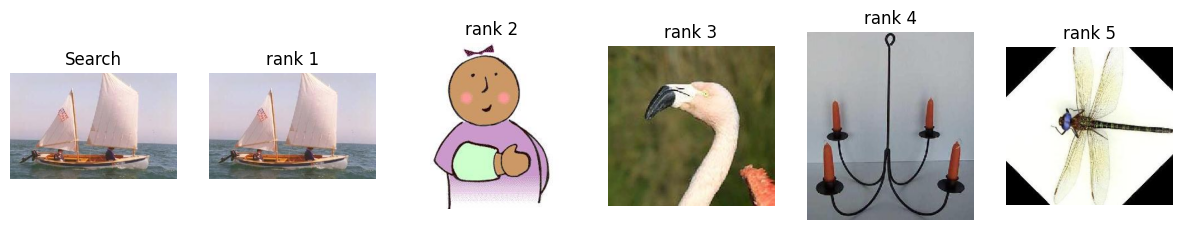

In [255]:
def visualize_retrieval(query_image_path, train_set, codebook, top_k=5, similarity_method='dot'):
    query_hist = image_table[image_table['file_name'] == query_image_path]['histogram'].values[0]
    similarities = compute_similarity(query_hist, train_set, method=similarity_method)
    sorted_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:top_k]
    
    plt.figure(figsize=(15, 5))
    # 显示查询图像
    plt.subplot(1, top_k+1, 1)
    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    plt.imshow(query_img)
    plt.title("Search")
    plt.axis('off')
    
    # 显示检索到的图像
    for i, (file, sim) in enumerate(sorted_similar):
        plt.subplot(1, top_k+1, i+2)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"rank {i+1}")
        plt.axis('off')
    plt.show()

# 示例可视化
sample_query = image_table[image_table['split'] == 'train']['file_name'].iloc[0]
visualize_retrieval(sample_query, image_table[image_table['split'] == 'train'], codebook, top_k=5, similarity_method='dot')

# 示例可视化
sample_query = image_table[image_table['split'] == 'test']['file_name'].iloc[100]
visualize_retrieval(sample_query, image_table[image_table['split'] == 'test'], codebook, top_k=5, similarity_method='dot')


In [ ]:
# # 示例代码：选择最佳 K 值
# import matplotlib.pyplot as plt

# k_values = [100, 200, 300, 400, 500]
# validation_mrr = []
# validation_top3 = []

# for k in k_values:
#     print(f"\n评估 K={k}")
#     # 执行 K-Means 聚类
#     kmeans = KMeans(n_clusters=k, random_state=42, verbose=0)
#     kmeans.fit(all_descriptors)
#     codebook = kmeans.cluster_centers_
    
#     # 计算训练集的 BoW 直方图
#     train_histograms = compute_bow_histograms(train_image_descriptors, codebook)
    
#     # 计算测试集的 BoW 直方图
#     test_histograms = compute_bow_histograms(test_image_descriptors, codebook)
    
#     # 创建图像表
#     train_data = create_image_table(train_histograms, test_histograms=None, categories=categories, data_path=data_path,split='train')
#     test_data = create_image_table(train_histograms, test_histograms=test_histograms, categories=categories, data_path=data_path,split='test')
#     image_table = pd.DataFrame(train_data + test_data)
    
#     # 检索和评估
#     mrr_test_dot, top3_test_dot = retrieve_and_evaluate(image_table, query_split='test', similarity_method='dot')
#     validation_mrr.append(mrr_test_dot)
#     validation_top3.append(top3_test_dot)

# # 绘制 K 值与性能指标的关系
# plt.figure(figsize=(12, 6))
# plt.plot(k_values, validation_mrr, marker='o', label='MRR（点积）')
# plt.plot(k_values, validation_top3, marker='s', label='前3名准确率（点积）')
# plt.xlabel('K 值（聚类数）')
# plt.ylabel('性能指标')
# plt.title('K 值与性能指标的关系')
# plt.legend()
# plt.grid(True)
# plt.show()
